# 1 - Introduction

In this notebook, I'm building a simple baseline model for the image recognition task of classifying mushrooms - the Mushi Identifier V1. The base dataset used for the training is [Danish Fungi 2020](https://arxiv.org/abs/2103.10107) (DF20), which was analyzed in the notebook ```00-jp-eda-raw-data.ipynb```.

I'm implementing the baseline model by feature extraction from [MobileNetV2](https://arxiv.org/abs/1801.04381) pre-trained on ImageNet. The resulting model will give an idea of the baseline performance achievable with a quick and simple approach. I'll improve upon the baseline in future iterations of the model.

Since I don't currently have a computing server or a strong GPU at my disposal, I'll do the model training on Google Colab. Hence, some of the cells (marked explicitly) will have Colab-specific code.

# 2 - Building the model

*Colab*: Mount the drive to access data and save models

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Define imports and paths

In [2]:
import csv
import pathlib

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

2021-10-10 21:22:39.867656: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-10 21:22:39.867681: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import os
import sys

# Add project root to Python path
project_path = os.path.abspath(os.path.join('..'))
if project_path not in sys.path:
    sys.path.append(project_path)
    

# Import custom functions    
from src.model.data_funcs import load_dataset, create_confusion_matrix, \
    plot_confusion_matrix, plot_loss_accuracy, create_class_report

In [4]:
# Model name - used for saving the model and related metadata
model_name = "mushi_identifier_v1"

# Processed data directory (relative to project root)
path_processed_dir = pathlib.Path(
    # "drive/MyDrive/colab_data/02_processed/" # Colab
    "../data/02_processed/"
)

# Model directory (relative to project root)
path_model_dir = pathlib.Path(
    # "drive/MyDrive/colab_models/" # Colab
    "../models/"
)

# Training and validation data directory
path_train_val_dir = path_processed_dir / "train_and_validation"

# Test data directory
path_test_dir = path_processed_dir / "test"

# Training logs directory
path_training_logs = path_model_dir / "training_logs" / (
        model_name + "_training_logs.csv")

# File for saving the names of the classes that the model is trained on
path_model_class_names = path_model_dir / (model_name + "_classes.csv")

# Saved model
path_saved_model = path_model_dir / (model_name + ".keras")

What happened to the data since the EDA: I verified that the mushroom images were not corrupt, split them into train/validation/test directories and organized the classes into subdirectories using the scripts ```src/data/s01_make_interim.py``` and ```src/data/s02_make_processed.py```. The images are now in the *processed* directory and they can be easily imported to keras.

Let's import the train, validation and test datasets. The DF20 authors provided a (public) test set with 10 % of the total data and for now I will match the size of the validation set to that. So the train-validation-test data split will be 80-10-10.

Now, this naive split might lead to unreliable validation scores. But it will get the modeling started. For future models, I will consider whether I should make a more balanced split or implement K-fold cross-validation to get more trustworthy validation scores.

In [23]:
# The ImageNet pretrained MobileNetV2 in Keras has a max input size of 224x224
image_size = (224, 224)

# Batch size
batch_size = 32

# Make a 80-10-10 split for the data
train_ds, validation_ds, test_ds = load_dataset(path_train_val_dir, path_test_dir, 
                                                train_val_split=0.11, image_size=image_size, batch_size=batch_size)

Found 5606 files belonging to 21 classes.
Using 4990 files for training.
Found 5606 files belonging to 21 classes.
Using 616 files for validation.
Found 623 files belonging to 21 classes.


In [6]:
# Print class names
class_names = train_ds.class_names
print(class_names)

# Save classes to file for use in inference
with open(path_model_class_names, "w") as f:
    writer = csv.writer(f)
    writer.writerow(["species"])
    writer.writerows(zip(class_names))

['boletus_edulis', 'boletus_pinophilus', 'boletus_reticulatus', 'cantharellus_cibarius', 'cortinarius_caperatus', 'craterellus_cornucopioides', 'craterellus_tubaeformis', 'hydnum_repandum', 'lactarius_deliciosus', 'lactarius_deterrimus', 'lactarius_rufus', 'lactarius_torminosus', 'lactarius_trivialis', 'leccinum_aurantiacum', 'leccinum_versipelle', 'leccinum_vulpinum', 'russula_claroflava', 'russula_decolorans', 'russula_paludosa', 'suillus_luteus', 'suillus_variegatus']


There are 21 classes for now, since that's what our raw dataset allows, but the later models will have more classes as we add more data. I am saving the class names here so I can easily connect them to this model's predictions during inference.

Let's check some of the images in the training set to make sure they were loaded correctly:

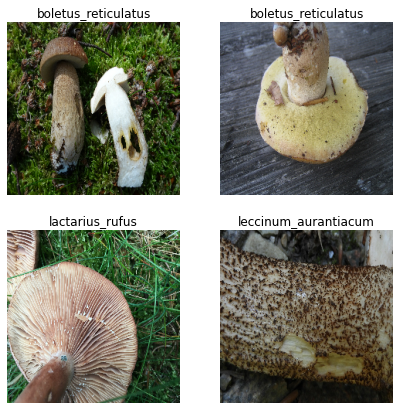

In [24]:
plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
    for j in range(4):
        ax = plt.subplot(2, 2, j + 1)
        plt.imshow(images[j].numpy().astype("uint8"))
        plt.title(class_names[labels[j]])
        plt.axis("off")

Now, let's do some preprocessing tasks for the dataset. First, I'll build a layer that will perform basic augmentations on the images, since the training dataset is small. This should introduce some variety to the samples and help with overfitting to the training set.

In [8]:
data_augmentation = keras.Sequential([
    # Could possibly add vertical flip here too, since the mushrooms are upside down in many photos
    keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

Let's view some of the augmented images. We did random horizontal flips, rotations and zooms:

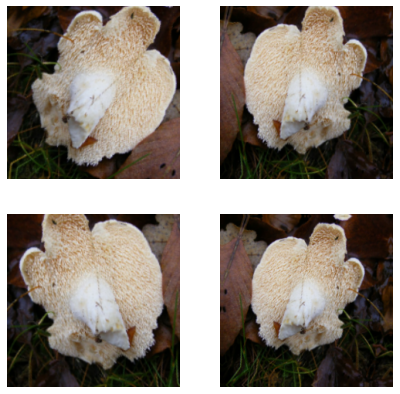

In [9]:
plt.figure(figsize=(7, 7))
for images, _ in train_ds.take(1):
    for j in range(4):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(2, 2, j + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Alright. Next, I'll do some configurations for the train and validation datasets to increase performance during model training. The ```.cache()``` method allows the images to stay in memory after they are loaded off disk during the first epoch, so they don't have to be reloaded for future epochs. The ```.prefetch()``` method allows data preprocessing and model execution to overlap during training, which speeds up the process.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

Now, I'll load the base model used for inference: MobileNetV2. I'm dropping the classification layers at the top of the network, since I'll attach the mushroom classifier there. The models weights are pre-trained on ImageNet, but as the DF20 authors pointed out, ImageNet has zero overlap with the DF20 dataset (none of the same photos), so our classifier shouldn't gain any extra benefit or bias from ImageNet.

Furthermore, I'll freeze the base model layers, since they shouldn't be trained.

In [11]:
# Add color channels to image dimensions
image_shape = image_size + (3,)

# Load MobileNetV2, drop the top layer
base_model = keras.applications.MobileNetV2(input_shape=image_shape,
                                            include_top=False,
                                            weights="imagenet")

# Freeze the base model so its weights won't be updated during training
base_model.trainable = False

Next, let's build the mushroom classifier on top of the base model. This is the part that we will actually train.

I'm adding the preprocessing and augmentation layers as a part of the model, so they will be easy to transfer between systems (and preprocessing can be directly used in inference). I'll also add an additional dropout layer to reduce overfitting. The exact dropout value could be tuned in the future.

I'm not defining the output activation here but instead using a raw output. This will be taken into account later while defining the loss function. I'm taking this approach, since it [should be better](https://datascience.stackexchange.com/questions/73093/what-does-from-logits-true-do-in-sparsecategoricalcrossentropy-loss-function) for numerical stability during the training. This also means, that I will need to add the softmax activation in the inference. The standard alternative would be using the softmax activation at the output.

In [12]:
# Define number of classes = number of output neurons
num_classes = len(class_names)

inputs = keras.Input(shape=image_shape)
x = data_augmentation(inputs)
# Rescale images for MobileNetV2, which expects image scale [-1, 1]
x = keras.applications.mobilenet_v2.preprocess_input(x)
# Set training to False due to keep batch normalization layers in inference mode 
# (though technically not needed unless we continue into fine-tuning)
x = base_model(x, training=False)
# Global pooling is better than flatten for small datasets 
# (https://github.com/keras-team/keras/issues/8470)
x = keras.layers.GlobalAveragePooling2D()(x)
# Dropout regularization
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(num_classes)(x)

model = keras.Model(inputs, outputs)

The model is now defined. Next, let's define the metrics.

For now, I will just track top-1 and top-3 accuracy during training. This is hardly ideal, since the dataset is highly imbalanced, but these accuracies were also used by the DF20 authors in their example models trained with the full DF20 dataset. Thus, by using these metrics I'll already be able to do a rough comparison to the results of the DF20 models.

I could also implement precision, recall and macro F1 score, which are more resistant to class imbalances. However, these have to be coded manually in Keras, since they are not built-in and/or [not supported for multiclass classification](https://github.com/tensorflow/addons/issues/1753). So for now, these scores will just be calculated in the final evaluation after training.

In [13]:
## Define metrics
metrics = [
    keras.metrics.SparseCategoricalAccuracy(name="acc"),  # "top-1 accuracy"
    keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top_3_acc")
]

The callbacks are quite standard: EarlyStopping to stop training once validation loss ceases to improve, ModelCheckpoint to save the best model obtained during training and CSVLogger to log training and validation loss and metrics to a csv file, from where they can be easily analyzed or visualized later.

I could also use LearningRateScheduler for dynamically reducing the learning rate during training, but I will try this later.

In [14]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        verbose=1,
        patience=10
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=path_saved_model,
        monitor="val_loss",
        verbose=1,
        save_best_only=True
    ),
    keras.callbacks.CSVLogger(
        filename=path_training_logs,
        append=True
    )
]

Let's compile the model. For now I'll use the Adam optimizer with the standard learning rate. Here the loss should have ```from_logits=True```, since I did not add a softmax activation to output layer earlier.

In [15]:
learning_rate = 0.001

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=metrics)

*Colab*: Here's an additional callback to TensorBoard, which allows following the training in real time.

In [16]:
# import datetime

# Define log dir path (create a timestamped subdirectory)
# log_dir = "drive/MyDrive/colab_models/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Add callback
# callbacks += [keras.callbacks.TensorBoard(log_dir=log_dir)]

# Launch tensorboard
# %load_ext tensorboard
# %tensorboard --logdir drive/MyDrive/colab_models/logs/

Time to train the model. The number of epochs is set quite high, since the EarlyStopping callback will interrupt the training once the validation loss stops improving.

In [17]:
## Train model

# model_history = model.fit(train_ds,
#                          epochs=100,
#                          callbacks=callbacks,
#                          validation_data=validation_ds)

# 3 - Results

In [18]:
# Load the model after training on Colab
model = keras.models.load_model(filepath=path_saved_model)

Starting off, let's check how the training went by plotting training and validation loss and metrics during training:

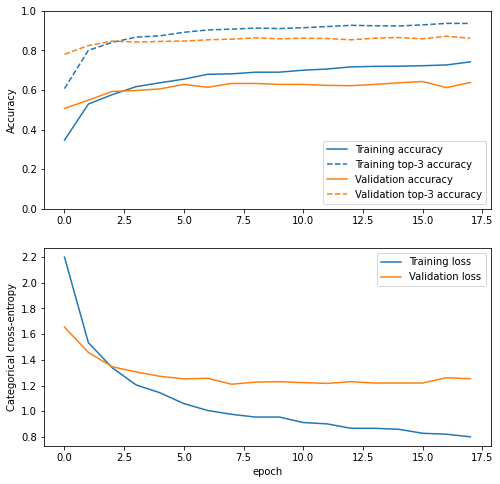

In [19]:
plot_loss_accuracy(from_logs=True, path_training_logs=path_training_logs)

The best validation score was obtained on epoch 8, and that's when the model was saved. Overall, the model trained very quickly. It would be a good idea to do some tuning (decreasing) for the learning rate to see if this would allow the training to explore the parameter space in more depth. 

Towards the start of the training, the validation scores are better than the training scores. This is most likely not a bug, but related to the batch normalization and dropout layers which are turned off for calculating validation loss. Furthermore, the validation score is calculated after each epoch while the training score is averaged over each epoch, which could give the validation scores an edge since the model trained very quickly. To some degree, this could also be related to the small size of the validation set.

Let's check how exactly the model does on the validation dataset. I'll calculate the top-1 and top-3 accuracies, precision, recall and F1-scores. Furthermore, I'll plot a normalized confusion matrix to get a visual idea of where the model went wrong.

Note: I'll just evaluate on the validation set for now, since I intend to do further tuning for the model and want to save the test set for later. However, the train/validation/test split is currently 80-10-10 so the validation set results might be noisy. In any case, even if no final conclusions should be made base on the results, they will give a rough idea of how the model is doing.

In [20]:
loss, top1_acc, top3_acc = model.evaluate(validation_ds)
print(f"Top-1 accuracy is: {top1_acc * 100:.2f} %")
print(f"Top-3 accuracy is: {top3_acc * 100:.2f} %")

20/20 [==============================] - 10s 387ms/step - loss: 1.2102 - acc: 0.6331 - top_3_acc: 0.8571
Top-1 accuracy is: 63.31 %
Top-3 accuracy is: 85.71 %


In [21]:
print(create_class_report(model, validation_ds, class_names))

                            precision    recall  f1-score   support

            boletus_edulis       0.83      0.60      0.70       131
        boletus_pinophilus       0.20      0.33      0.25         3
       boletus_reticulatus       0.41      0.44      0.42        32
     cantharellus_cibarius       0.77      0.82      0.79        44
     cortinarius_caperatus       0.33      0.67      0.44         3
craterellus_cornucopioides       0.77      0.74      0.76        23
   craterellus_tubaeformis       0.69      0.77      0.73        48
           hydnum_repandum       0.71      0.96      0.82        28
      lactarius_deliciosus       0.68      0.49      0.57        43
      lactarius_deterrimus       0.52      0.83      0.64        30
           lactarius_rufus       0.63      0.61      0.62        28
      lactarius_torminosus       0.57      0.32      0.41        25
       lactarius_trivialis       0.14      0.50      0.22         2
      leccinum_aurantiacum       0.42      0.59

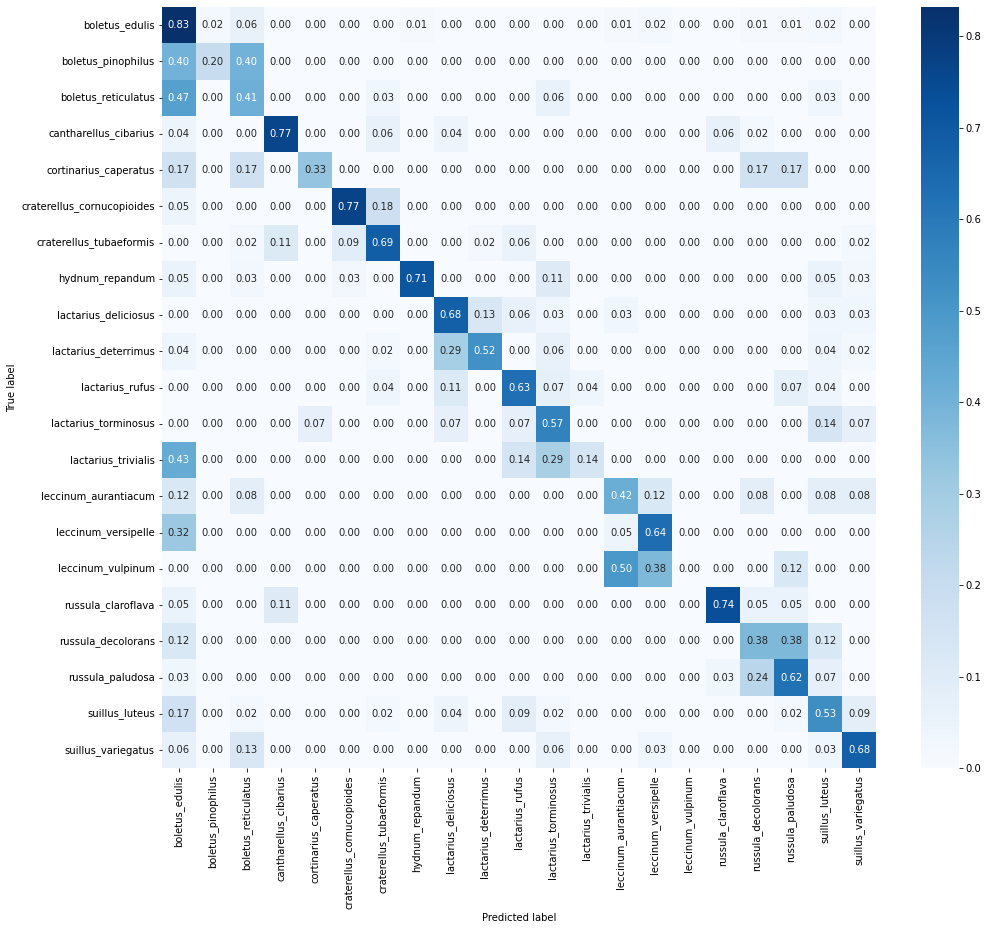

In [22]:
cm = create_confusion_matrix(model, validation_ds)
plot_confusion_matrix(cm, class_names, normalize=True)

What level of results should I be expecting, i.e. what should I compare the baseline model results to?

Well, the DF20 authors trained popular CNN models with the entire DF20 dataset. With a fine-tuned MobileNetV2 evaluated on the test set, the authors obtained a top-1 accuracy of 69.77 %, top-3 accuracy of 85.01 % and macro-averaged F1 score of 0.602. In my baseline model, top-1 accuracy (63.31 %) and F1 scores  (0.54) are clearly lower, but the top-3 accuracy (85.71 %) reaches a similar level. 

Looking at the performance of individual classes, Boletus edulis is expectedly doing well, since it had a over 800 images in the dataset, nearly double the second contender. On the other hand, the classes with a low image count, such as Lactarius trivialis and Leccinum vulpinum, seem to be struggling. Furthermore, the model is confusing some classes with one another, like the Boletus reticulatus for Boletus edulis. This was to be expected, since some of the classes look very similar and distinguishing them is a fine-grained task.

All in all, there is a lot of work ahead, especially for smoothing out the class imbalances. Still, the baseline model is performing surprisingly well compared to the more advanced DF20 authors' model for how simple and light it is.

# 4 - Summary

The baseline model (Mushi Identifier V1) built in this notebook already reached accuracies close to the fine-tuned MobileNetV2-based model presented in the DF20 publication. This is a promising result, but the baseline model should definitely see some improvements. Here are the main steps that will follow this notebook:

1. Consider dynamically adjusting the learning rate, since it currently seems a bit high
2. Attempt fine tuning instead of feature extraction, if data allows for it

In addition, I will consider the following steps after the first three are done:

3. Implement K-fold cross-validation to get more reliable validation scores
4. Do hyperparameter tuning for the learning rate and batch size


And of course, I should get more photos for the classes with a low amount of samples. This will be the most reliable way to improve the results.

In any case, now I have a model with the base functionality: the Mushi Identifier V1. I can already start planning and sketching the deployment framework based on it.